In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
import os

# Lets create a function to load all our CSV files and store them in a single data frame.

Since we are dealing with time series analysis, we will create a column for time and day.

In [8]:
def load_data():                # This line defines a function named load_data that will load and combine all CSV files.    
    all_files = []                  #this initializes an empty list all_files which will be used to store data from all the loaded CSV files.
    for day in range(1, 8):                     #This outer loop iterates over the days from 1 to 7 (inclusive)
        for time in ['0000', '0800', '1600']:       # This inner loop iterates over three time periods: '0000', '0800', and '1600'.
            file_path = f'day{day}_{time}.csv'      # This constructs the file path string for each combination of day and time. 
            if os.path.exists(file_path):           #This checks if the constructed file path exists.
                df = pd.read_csv(file_path)         #If the file exists, it reads the CSV file into a DataFrame
                df['day'] = day                     #This adds a new column day to the DataFrame df with the current day value.
                df['time'] = time                   # This adds a new column time to the DataFrame df with the current time value.
                all_files.append(df)                # This appends the DataFrame df to the list 
            else:
                print(f"File {file_path} not found.")   #If the file does not exist, it prints a message indicating that the file was not found.
    return pd.concat(all_files, ignore_index=True)      #This concatenates all the DataFrames stored in the all_files list into a single DataFrame, ignoring the original index values to create a continuous index.

data = load_data()          #Calls the load_data function and stores the resulting DataFrame in the variable data.

# Lets Convert columns to numeric, If there are any conversion errors (e.g., if a cell contains a non-numeric value), it coerces the errors by setting those values to NaN.
data['Baseline: People Moving'] = pd.to_numeric(data['Baseline: People Moving'], errors='coerce')
data['Crisis: People Moving'] = pd.to_numeric(data['Crisis: People Moving'], errors='coerce')
data['x0'] = pd.to_numeric(data['x0'], errors='coerce')
data['y0'] = pd.to_numeric(data['y0'], errors='coerce')
data['x1'] = pd.to_numeric(data['x1'], errors='coerce')
data['y1'] = pd.to_numeric(data['y1'], errors='coerce')

# Drop rows with any NaN values
data.dropna(inplace=True)                 #Drops all rows in the DataFrame data that contain any NaN values. The inplace=True argument modifies the DataFrame in place, rather than returning a new DataFrame.

In [10]:
#Lets check the first 10 values
data.head(10)

,Unnamed: 0,index,Baseline: People Moving,Crisis: People Moving,x0,y0,x1,y1,day,time
0,0,7515,14.000000,30,62.788086,8.425543,62.963867,8.425543,1,0000
1,1,7517,11.000000,24,62.788086,8.425543,63.227540,8.256863,1,0000
2,2,7519,16.666667,45,62.788086,8.425543,63.315430,8.172468,1,0000
3,3,7520,14.000000,31,62.788086,8.425543,63.491210,8.425543,1,0000
4,4,7542,13.000000,38,62.788086,9.350634,63.139650,9.350634,1,0000
5,5,7562,12.000000,28,62.788086,9.434505,62.963867,9.098787,1,0000
6,6,7563,34.133333,32,62.788086,9.434505,62.963867,9.434505,1,0000
7,7,7565,14.000000,45,62.788086,9.434505,63.051758,9.098787,1,0000
8,8,7566,22.333333,56,62.788086,9.434505,63.139650,9.350634,1,0000
9,9,7567,16.666667,34,62.788086,9.434505,63.227540,9.685890,1,0000


# Exploratory Data Analysis EDA

In [11]:
# Lets have a clear view of the data amd the data types for data validity
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14159 entries, 0 to 14158
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               14159 non-null  int64  
 1   index                    14159 non-null  int64  
 2   Baseline: People Moving  14159 non-null  float64
 3   Crisis: People Moving    14159 non-null  int64  
 4   x0                       14159 non-null  float64
 5   y0                       14159 non-null  float64
 6   x1                       14159 non-null  float64
 7   y1                       14159 non-null  float64
 8   day                      14159 non-null  int64  
 9   time                     14159 non-null  object 
dtypes: float64(5), int64(4), object(1)
memory usage: 1.1+ MB


In [12]:
# Lets check for any null values. if theres any we can either convert to 0 or find the mean of the column and fill in missing values with the mean
data.isnull().sum()

Unnamed: 0                 0
index                      0
Baseline: People Moving    0
Crisis: People Moving      0
x0                         0
y0                         0
x1                         0
y1                         0
day                        0
time                       0
dtype: int64

In [13]:
#Lets check the descriptive statistics of the data. This tells us what has happened in the past
data.describe()

,Unnamed: 0,index,Baseline: People Moving,Crisis: People Moving,x0,y0,x1,y1,day
count,14159.000000,14159.000000,14159.000000,14159.000000,14159.000000,14159.000000,14159.000000,14159.000000,14159.000000
mean,397.902394,8416.429903,28.916440,76.775478,64.843849,10.480703,64.851037,10.476967,3.843774
std,268.912049,2600.544326,45.060578,123.669774,1.002030,1.317154,0.986637,1.319519,1.940462
min,0.000000,2040.000000,10.000000,10.000000,62.612305,8.425543,62.963867,8.088038,1.000000
25%,168.000000,7281.500000,12.615385,33.000000,63.930664,9.266724,63.930664,9.266724,2.000000
50%,354.000000,8881.000000,16.666667,47.000000,65.424805,10.687874,65.424805,10.687874,4.000000
75%,611.000000,10261.000000,28.000000,75.000000,65.688480,11.766699,65.688480,11.766699,5.000000
max,1072.000000,12536.000000,840.428571,2384.000000,65.864260,12.756109,65.864260,12.673901,7.000000


# PLOTTING CORRELATION MATRIX

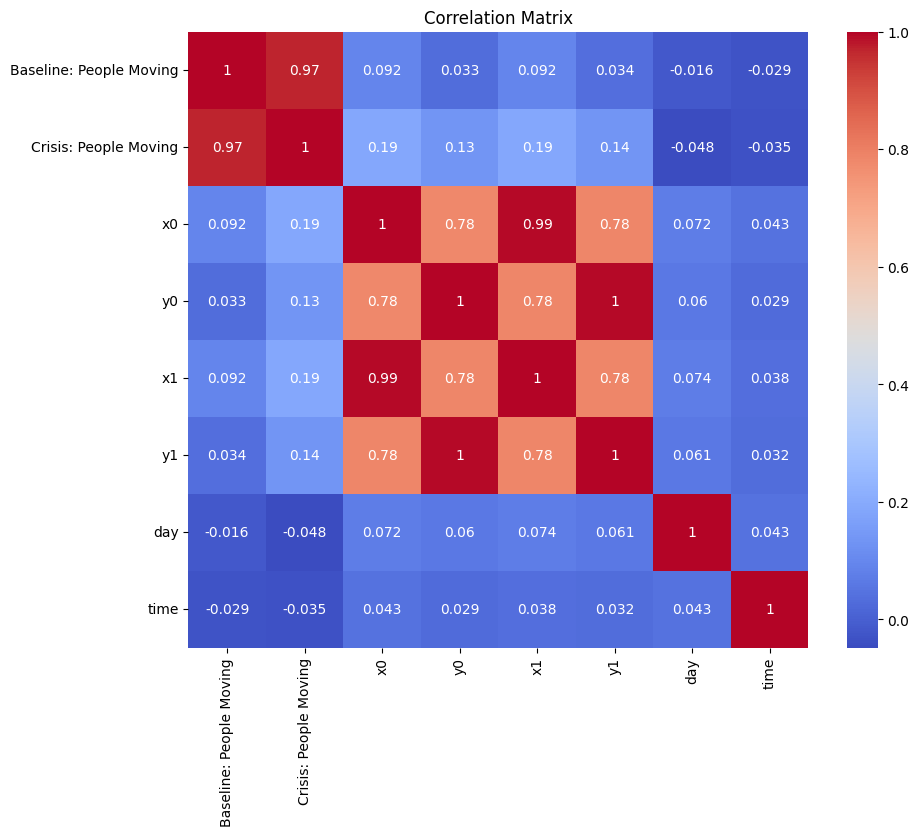

In [14]:
# Lets plot a correlation matrix to see how correlated the variables are 
correlation_matrix = data[['Baseline: People Moving', 'Crisis: People Moving', 'x0', 'y0', 'x1', 'y1','day','time']].corr()
plt.figure(figsize=(10, 8)) # the size of our diagram
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') #using coolwarm as our heat map
plt.title('Correlation Matrix')
plt.show()

# Explanation of Correlation matrix
1) High correlation (0.97) between Baseline and Crisis movement: This indicates that the routes with higher baseline movement also had higher crisis movement.

2) Moderate correlation between spatial coordinates: High correlations between x0 and x1 (0.99) and between y0 and y1 (1.0) suggest that movements are generally directional and consistent between specific origin-destination pairs.

3) Low correlation with day and time: The day and time variables show very low correlations with other factors, indicating that daily and time-specific changes are relatively independent of baseline and crisis movement patterns.

# PROBLEM STATEMENT 1

# DISTRIBUTION OF PEOPLE MOVING

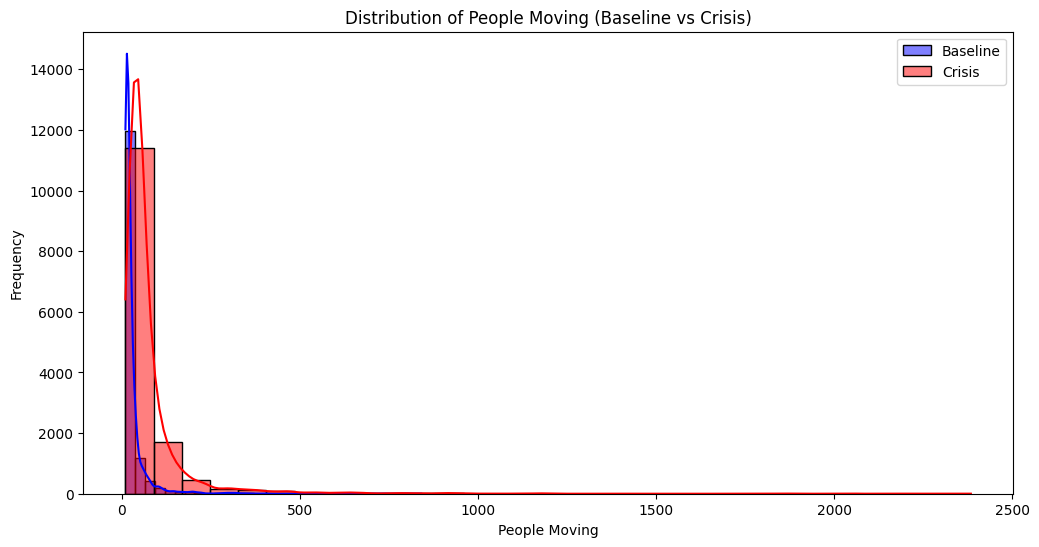

In [12]:
 # Lets create Distribution plots to see the distribution of our data
plt.figure(figsize=(12, 6))
sns.histplot(data['Baseline: People Moving'], kde=True, bins=30, color='blue', label='Baseline')
sns.histplot(data['Crisis: People Moving'], kde=True, bins=30, color='red', label='Crisis')
plt.legend()
plt.title('Distribution of People Moving (Baseline vs Crisis)')
plt.xlabel('People Moving')
plt.ylabel('Frequency')
plt.show()

# Explanation of Distribution Graph
1) Distribution shift: The Crisis (Colored in Red) period shows a decrease in the number of people moving compared to the Baseline(colored in blue).

2) High frequency of low movement: Both distributions are heavily skewed towards lower numbers, this indicate that  most routes had lower mobility even during baseline periods(Before crisis).

# REDUCTION IN PEOPLE MOVING OVER TIME

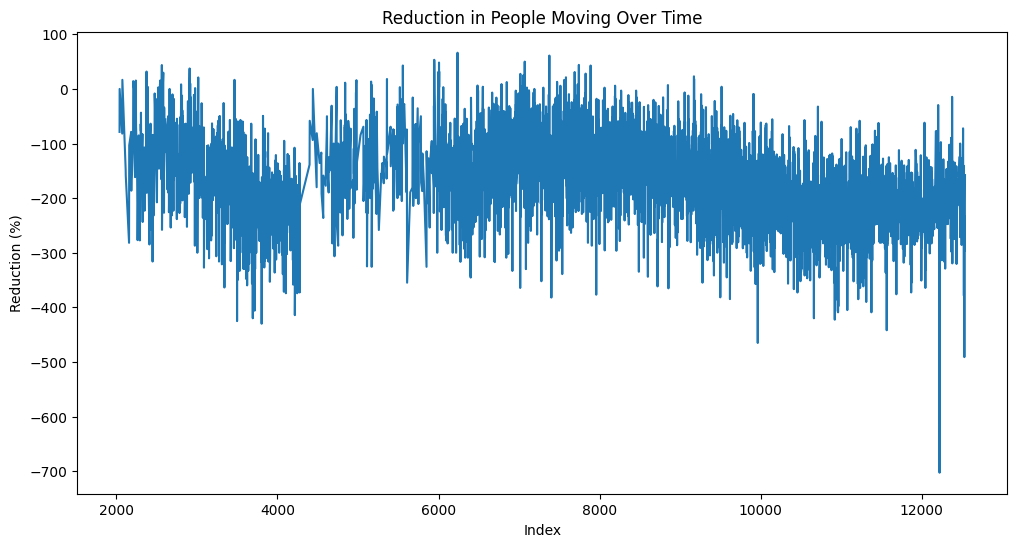

In [11]:
#Lets plot a graph to see the reduction of people moving over time
data['Reduction'] = (data['Baseline: People Moving'] - data['Crisis: People Moving']) / data['Baseline: People Moving'] * 100 #formula for reduction is (baseline - crisis) / (baseline) *100
reduction_over_time = data.groupby('index')['Reduction'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=reduction_over_time, x='index', y='Reduction')
plt.title('Reduction in People Moving Over Time')
plt.xlabel('Index')
plt.ylabel('Reduction (%)')
plt.show()

# Explanation of Reduction in People Moving Over time
The line plot shows the reduction in people moving over time, indexed by the data points.

Y-axis: Represents the reduction in mobility as a percentage.
# Observation: 
The reduction in mobility fluctuates significantly over time, with some periods showing a higher reduction than others (Particularly period before crisis).
# Insight: 
There are instances where the reduction in mobility is negative, this indicate an increase in mobility compared to the baseline. The overall trend shows a reduction in mobility, but the fluctuations suggest that the reduction is not consistent across all time periods and routes.


# MOBILITY REDUCTION OVER TIME

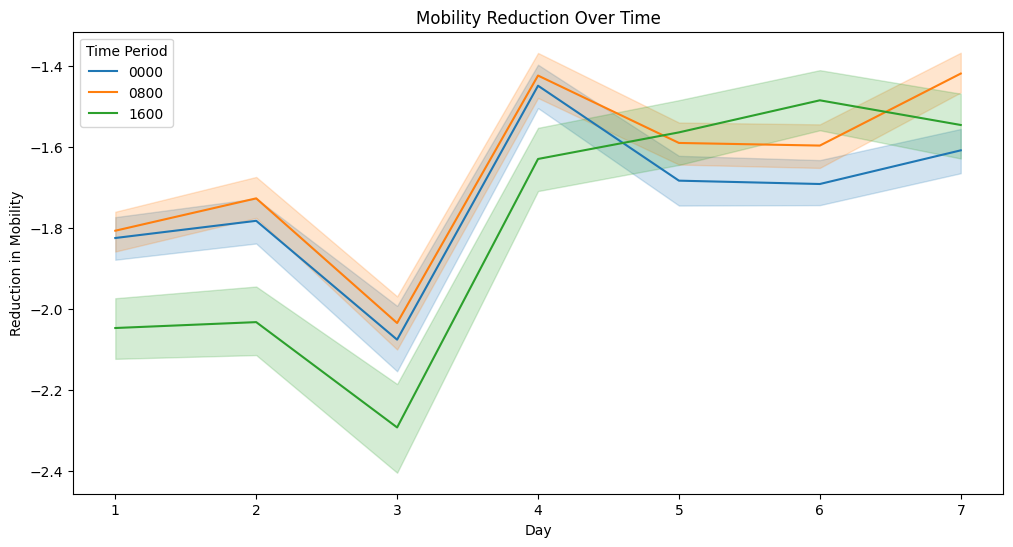

In [4]:
# Calculate the reduction in mobility
data['reduction'] = (data['Baseline: People Moving'] - data['Crisis: People Moving']) / data['Baseline: People Moving']

# Plot the reduction over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='day', y='reduction', hue='time')
plt.title('Mobility Reduction Over Time')
plt.xlabel('Day')
plt.ylabel('Reduction in Mobility')
plt.legend(title='Time Period')
plt.show()

# Explanation of the graph
The Line plot above shows the reduction in mobility over 7 days, with different lines for each time period (0000, 0800,1600).

I) Blue Line: Time period 0000(midnight to 8 AM)

II) Orange Line: Time period 0800 (8 AM to 4 PM)

III) Green Line: Time period 1600 (4 PM to midnight)

# A) Shaded Areas: 
This represent the confidence intervals for each time period.

# B) Overall Trend: 
The reduction in mobility is consistently negative across all days and time periods, this indicates a general decrease in mobility due to COVID crisis.

# C) Day-wise Analysis:

I) Day 1 to Day 3: The reduction in mobility is relatively stable, with slight variations across the time periods.

II) Day 4: There is a significant increase in the reduction of mobility across all time mobility across all time periods, indicating a possible event or stricter enforcement of social distancing measures on this day.

III) Day 5 to Day 7: The reduction in mobility starts to decrease (less negative), suggesting a slight relaxation or adaptation to the measures.

# D) Time Period Analysis:

I) Blue Line (0000): The reduction in mobility during midnight to 8 AM is generally less pronounced compared to other time periods, indicating that fewer people are moving during this hours even before the crisis.

II) Orange Line(0800): The reduction in mobility during 8 AM to 4 PM shows more significant fluctuations, likely due to work and school-related movements.

III) Green Line(1600): The reduction in mobility during 4 PM to midnight is the most pronounced, especially on Day 4, suggesting that evening activities are more affected by the crisis.

# E) Confidence Intervals: 
The shaded areas around each line represent the confidence intervals, this indicates the variability in reduction of mobility. The confidence intervals are wider for the 1600 time period, suggesting more variability in mobility reduction during the evening hours.

# PROBLEM STATEMENT 2

# REDUCTION IN MOBILITY BY AREA

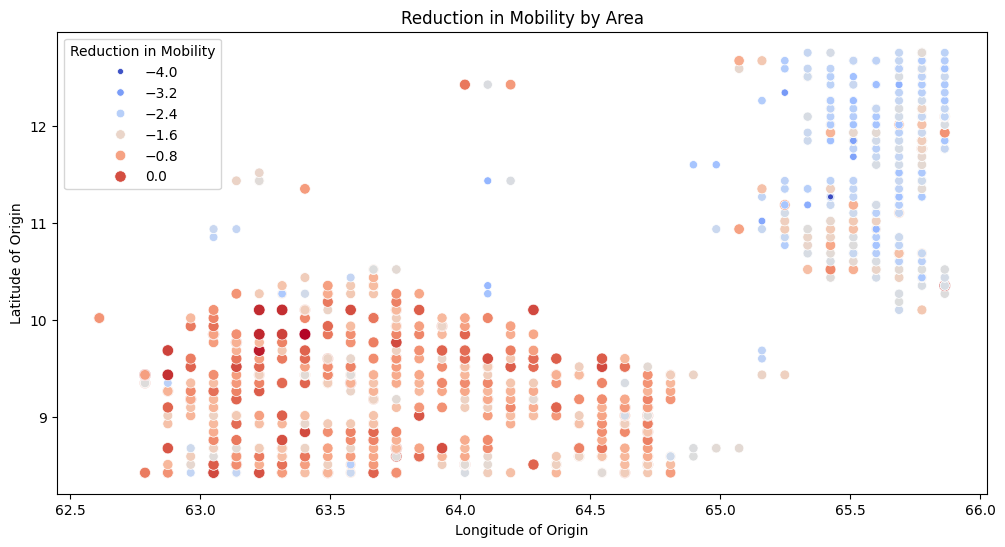

In [6]:
# LEts Group by origin and destination coordinates
grouped_data = data.groupby(['x0', 'y0', 'x1', 'y1']).mean(numeric_only=True).reset_index()

# Lets Plot the reduction by area
plt.figure(figsize=(12, 6))
sns.scatterplot(data=grouped_data, x='x0', y='y0', size='reduction', hue='reduction', palette='coolwarm')
plt.title('Reduction in Mobility by Area')
plt.xlabel('Longitude of Origin')
plt.ylabel('Latitude of Origin')
plt.legend(title='Reduction in Mobility')
plt.show()

# Explanation of the graph
The Scatter plot shows the reduction in mobility by area, with the size and color of the points representing the reduction.
Axes:

I) X-axis: Longitude of Origin

II) Y-axis: Latitude of Origin

# Color and Size:
I) The color and size of the points represent the reduction in mobility, with darker and larger points indicating a greater reduction.

# Observation: 
The scatter plot shows the spatial distribution of mobility reduction across different areas.

# Insight: 
Areas with the highest reduction in mobility are represented by the darkest and largest points.Areas with the least reduction in mobility are represented by the lightest and smallest points. This visualization helps us to  identify which areas are adhering to social distancing measures and which are not.


# CLUSTERING AREA BASED ON MOBILITY REDUCTION

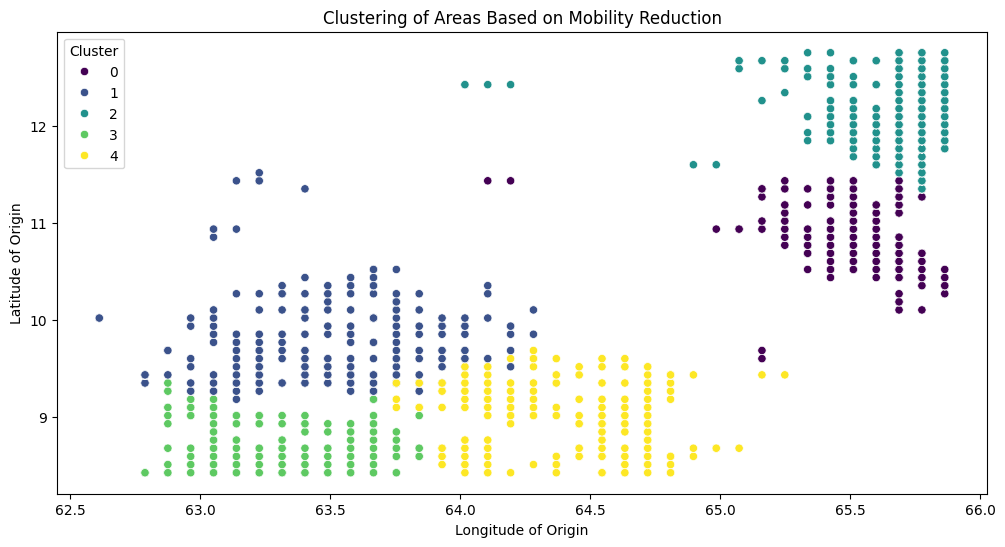

In [15]:
# lets Prepare data for clustering. These are the columns we want to cluster
clustering_data = grouped_data[['x0', 'y0', 'x1', 'y1', 'reduction']]

# next we Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(clustering_data)
grouped_data['cluster'] = kmeans.labels_

# lets Plot clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=grouped_data, x='x0', y='y0', hue='cluster', palette='viridis')
plt.title('Clustering of Areas Based on Mobility Reduction')
plt.xlabel('Longitude of Origin')
plt.ylabel('Latitude of Origin')
plt.legend(title='Cluster')
plt.show()

# Explanation of Graph for Clustering Areas Based on mobility 
The Scatter plot above shows clusters of areas based on mobility reduction.

I) X-axis: Longitude of Origin

II) Y-axis: Latitude of Origin

# Color and Size:
I) Different colors represent different clusters.

# Interpretation:

I) Cluster 0 (Purple): These areas represent regions with moderate reduction in mobility they are fairly dispersed but show a concentration around the latitude of 10 and longitudes between 64.5 and 65.5.

II) Cluster 1 (Blue): These areas indicates a slightly higher reduction in mobility compared to Cluster 0.These regions are more spread out across different longitudes, particularly between 63 and 64.5.

III) Cluster 2 (Teal): This cluster represents areas with significant reduction in mobility. These areas are mainly concentrated in the upper right of the plot, indicating a specific geographical region with high compliance or stricter enforcement.

IV) Cluster 3 (Green): These regions show a lower reduction in mobility, suggesting these areas might have essential routes or lower compliance. This is spread across the lower left region of the plot, indicating a different set of geographical factors influencing mobility.

V) Cluster 4 (Yellow): This cluster shows areas with the least reduction in mobility, indicating potentially critical routes, essential services, or non-compliance with mobility reduction measures. This Cluster is concentrated in the lower center region, showing that specific geographical areas have minimal reduction.

# Observation: 
The scatter plot shows the spatial distribution of clusters based on mobility reduction.
# Insight: 
Each cluster represents areas with similar mobility reduction patterns. This visualization helps us identify groups of areas that exhibit similar behavior, which can be useful for targeted interventions.

# VULNERABLE AREAS WITH LEAST REDUCTION IN MOBILITY

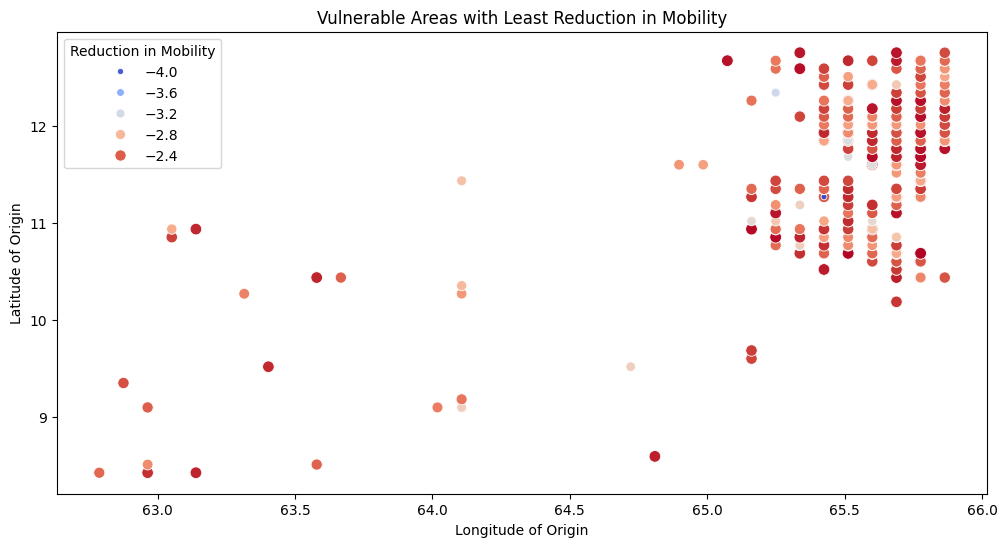

In [10]:
#The code below is used to calculate vulnurable areas where the reduction in mobility is in the bottom 25% of all reductions.
# The vulnerable areas are those areas with the least reduction
vulnerable_areas = grouped_data[grouped_data['reduction'] < grouped_data['reduction'].quantile(0.25)]

# lets Plot vulnerable areas
plt.figure(figsize=(12, 6))
sns.scatterplot(data=vulnerable_areas, x='x0', y='y0', size='reduction', hue='reduction', palette='coolwarm')
plt.title('Vulnerable Areas with Least Reduction in Mobility')
plt.xlabel('Longitude of Origin')
plt.ylabel('Latitude of Origin')
plt.legend(title='Reduction in Mobility')
plt.show()

# Explanation of Graph for vulnerable Areas with Least Reduction in Mobility
The Scatter plot above highlights areas with the least reduction in mobility.

I) X-axis: Longitude of Origin

II) Y-axis: Latitude of Origin

# Color and Size:
The color and size of the points represent the reduction in mobility, with lighter and smaller points indicating the least reduction.

# Observation:
 The scatter plot shows the spatial distribution of areas with the least reduction in mobility.

# Insight:
Vulnerable areas with the least reduction in mobility are represented by the lightest and smallest points.This visualization helps identity areas that may need additional support or targeted interventions to improve compliance with social distancing measures.

In [16]:
# # Saving the results to a CSV file
# grouped_data.to_csv('mobility_analysis_results.csv', index=False)

# FURTHER ANALYSIS

Plotting  the geographic location of the origin and destination using plotly 

In [6]:
# Load the data
df = pd.read_csv('mobility_analysis_results.csv')

# Convert columns to numeric if they are not already
df['x0'] = pd.to_numeric(df['x0'], errors='coerce')
df['y0'] = pd.to_numeric(df['y0'], errors='coerce')
df['x1'] = pd.to_numeric(df['x1'], errors='coerce')
df['y1'] = pd.to_numeric(df['y1'], errors='coerce')

# Create a DataFrame for origin points
origin_df = df[['x0', 'y0']].copy()
origin_df['type'] = 'Origin'

# Create a DataFrame for destination points
destination_df = df[['x1', 'y1']].copy()
destination_df['type'] = 'Destination'

# Rename columns to match for concatenation
origin_df.columns = ['Longitude', 'Latitude', 'Type']
destination_df.columns = ['Longitude', 'Latitude', 'Type']

# Concatenate origin and destination DataFrames
combined_df = pd.concat([origin_df, destination_df])

# Plot the map
fig = px.scatter_geo(combined_df,
                     lon='Longitude',
                     lat='Latitude',
                     color='Type',
                     title='Origin and Destination Locations',
                     projection='natural earth')

fig.show()